# ECSE415 Assignment 2
# Mai Zeng
# 260782174

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import segmentation, color
from skimage.future import graph
from skimage.segmentation import quickshift
import os
import math
from PIL import Image

In [15]:
# (Suggestion: Make a function which takes list of images as arguments 
# and delivers list of HoG features as output. The same function can
# be used during testing.)
def HoG_features(images):
    
    cell_size = (8, 8)  # h x w in pixels
    block_size = (2, 2)  # h x w in cells
    nbins = 9  # number of orientation bins

    hog_feats = []
    for image in images:
        # create HoG Object
        # winSize is the size of the image cropped to multiple of the cell size
        # all arguments should be given in terms of number of pixels
        hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                          img.shape[0] // cell_size[0] * cell_size[0]),
                                _blockSize=(block_size[1] * cell_size[1],
                                            block_size[0] * cell_size[0]),
                                _blockStride=(cell_size[1], cell_size[0]),
                                _cellSize=(cell_size[1], cell_size[0]),
                                _nbins=nbins)
        n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1]) #15//7 then it will give me an int

        # 3. Calculate and store the mean feature map across training images.
        # Compute HoG features
        # This hog_feats is just a long vector
        # need to resize
        hog_feat = hog.compute(img) \
                       .reshape(n_cells[1] - block_size[1] + 1,
                                n_cells[0] - block_size[0] + 1,
                                block_size[1], block_size[0], nbins) \
                       .transpose((1, 0, 3, 2, 4))  # index blocks by rows first
            # Preview
#         for i in sorted(range(8)):
#             plt.figure(figsize = (10,10))
#             plt.pcolor(hog_feat[:, :, 0,0,i])
#             #plt.imshow(img, cmap='gray')
#             plt.gca().invert_yaxis()
#             plt.gca().set_aspect('equal', adjustable='box')
#             plt.title("HOG bin = {}, block = 1".format(i)), plt.xticks([]), plt.yticks([])
        hog_feats.append(hog_feat)
    return hog_feats



## 1 Invariance of SIFT Features
### 1.1 Invariance Under Changes in Scale

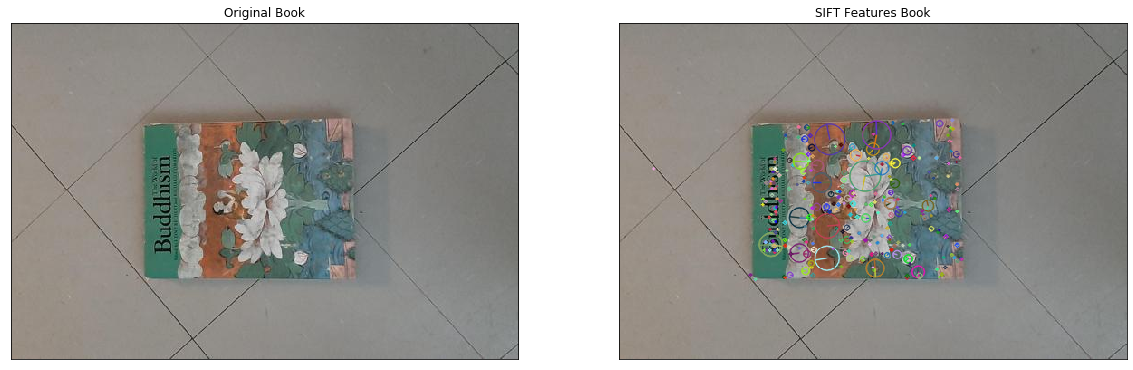

Num keypoints: 385


In [5]:
# load image 
img = cv2.imread("book.jpg")
# copy image
img_disp = img.copy()
# convert to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_disp = cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB)

# 1. Compute SIFT keypoints for the reference image
# create a SIFT object
sift = cv2.xfeatures2d.SIFT_create() # replace with SURF_create() for SURF features

# detect SIFT features, with no masks
# 'None' is a mask but here is no masks so it is none
# Sometime we want to just compute the key points just in the mask
keypoints = sift.detect(img, None)

# draw the keypoints
cv2.drawKeypoints(img, keypoints, img_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# display
plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(img)
plt.title("Original Book"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_disp)
plt.title("SIFT Features Book"), plt.xticks([]), plt.yticks([])
plt.show()

# num of SIFT keypoints
print('Num keypoints: '+ str(len(keypoints)))

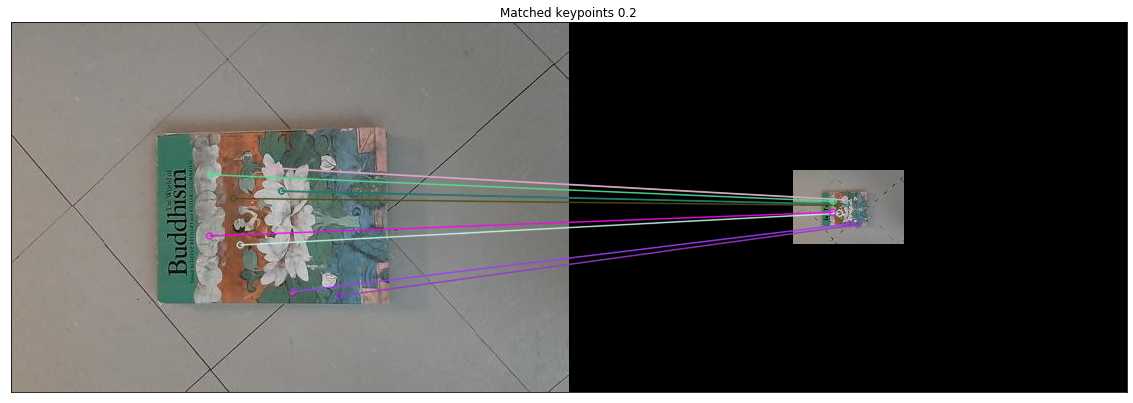

descriptors size: (385, 128)


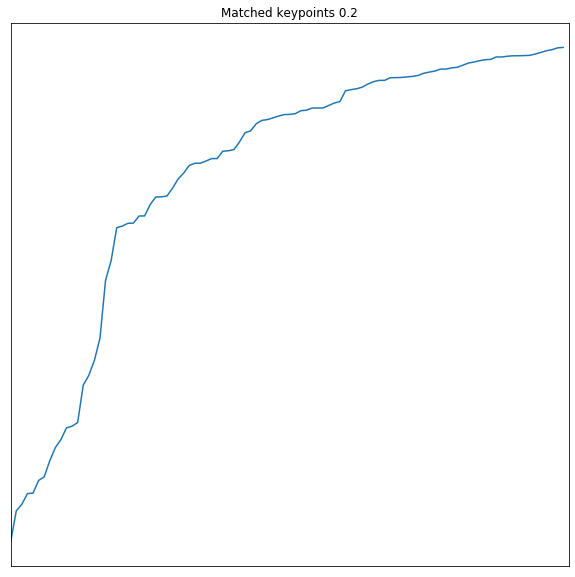

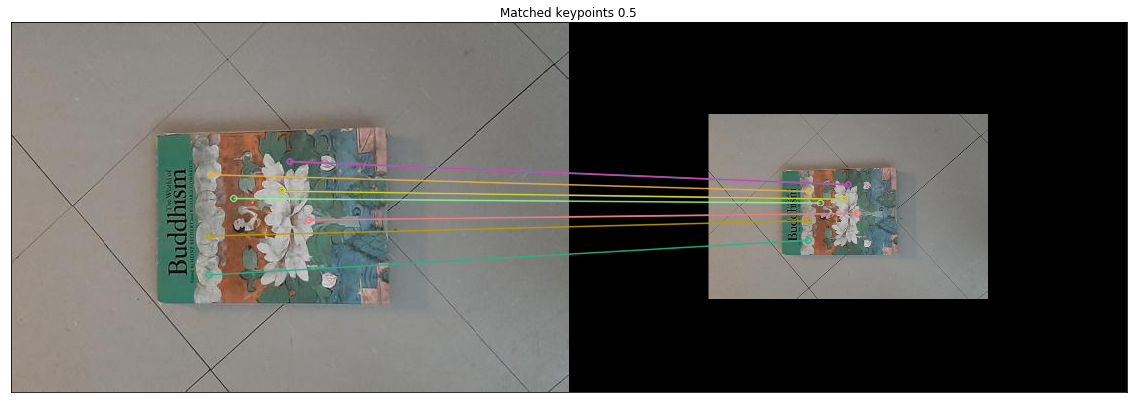

descriptors size: (385, 128)


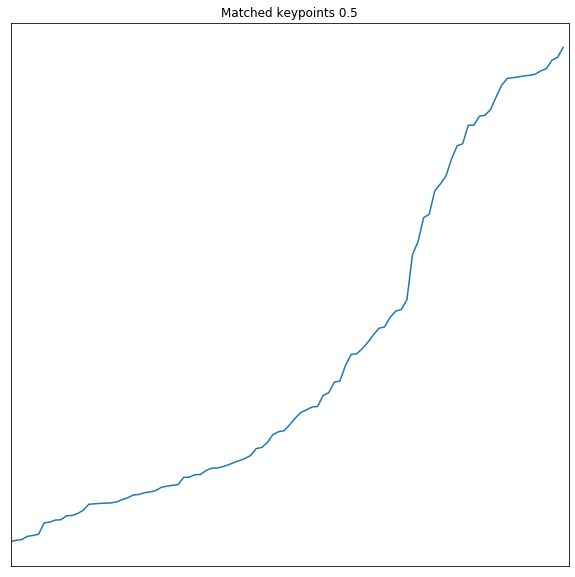

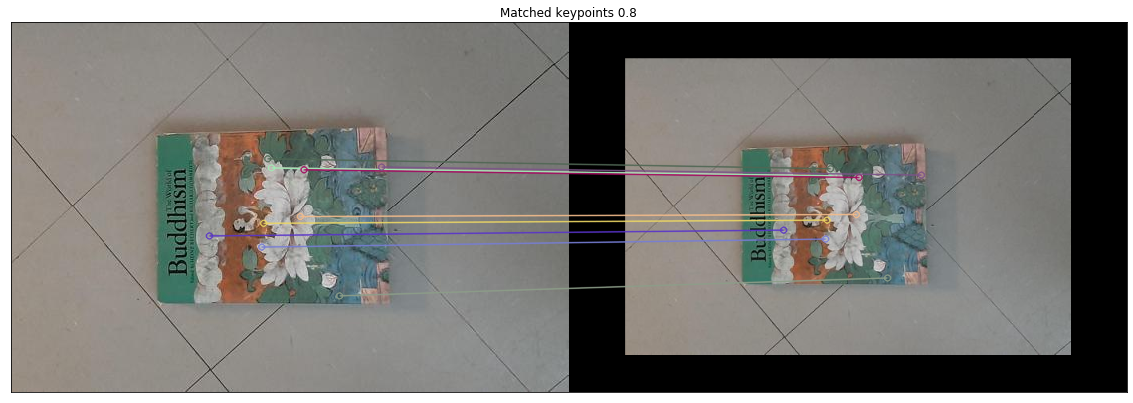

descriptors size: (385, 128)


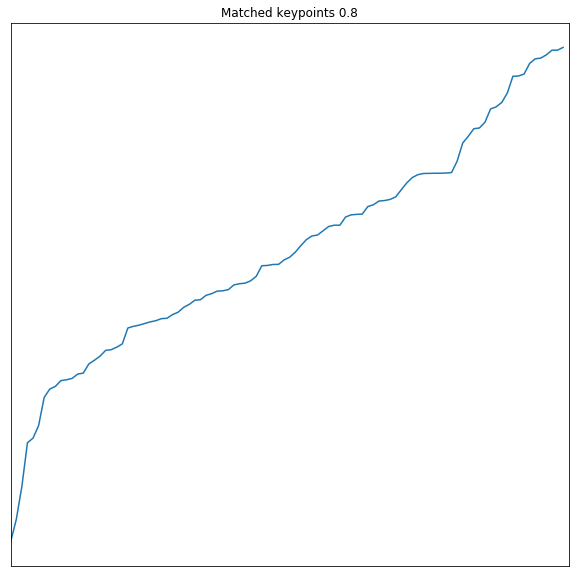

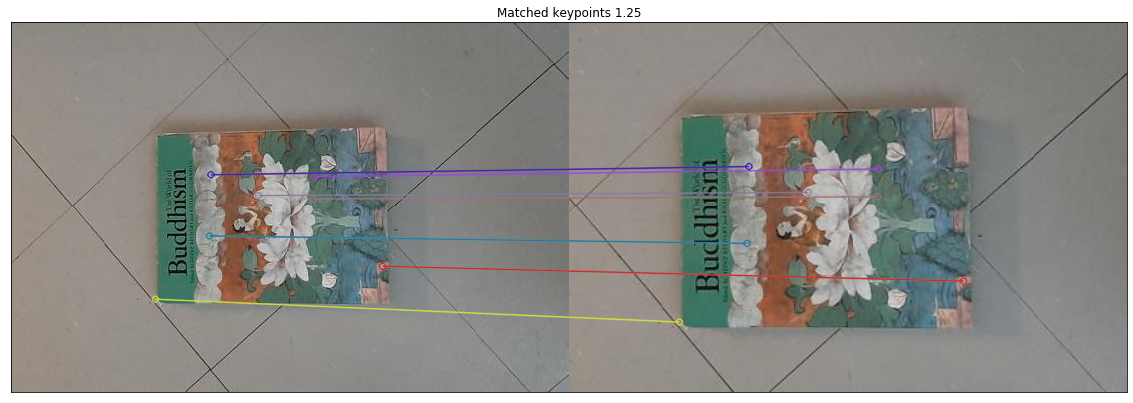

descriptors size: (385, 128)


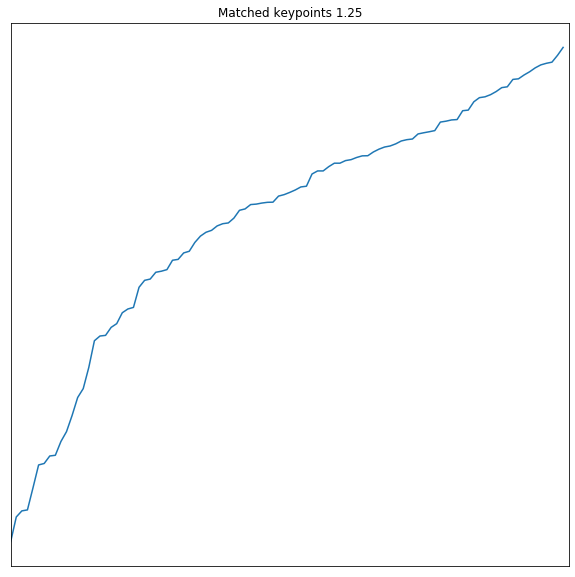

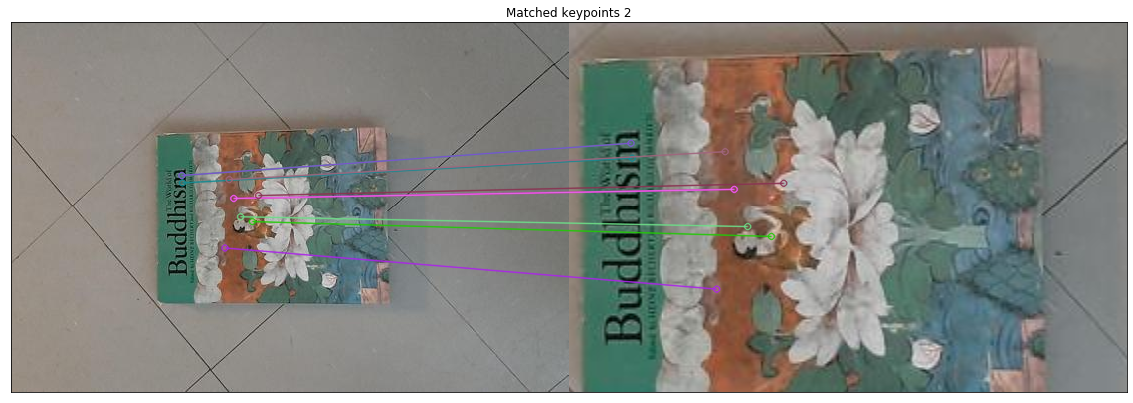

descriptors size: (385, 128)


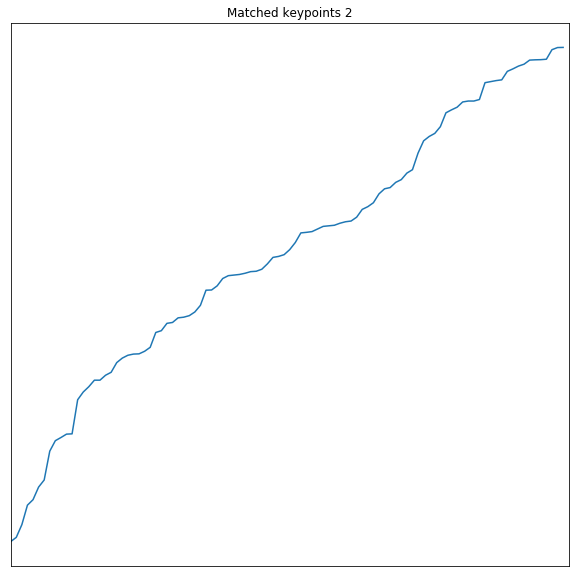

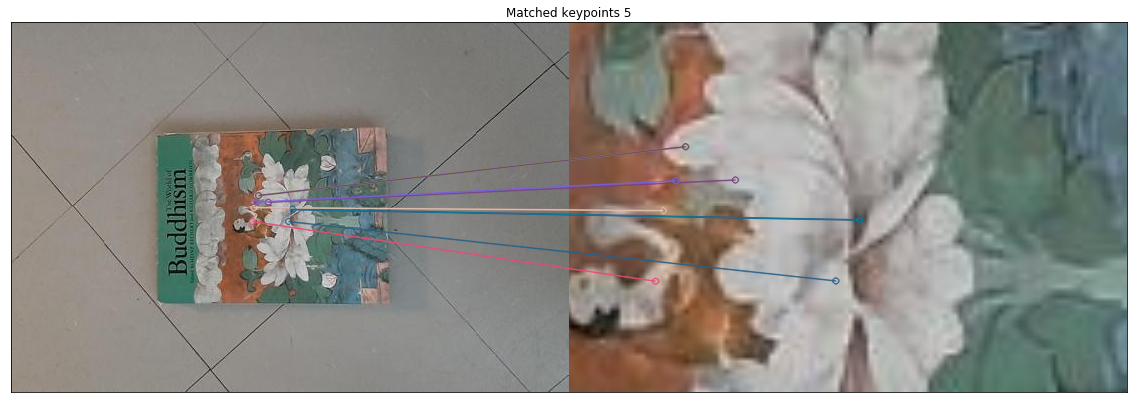

descriptors size: (385, 128)


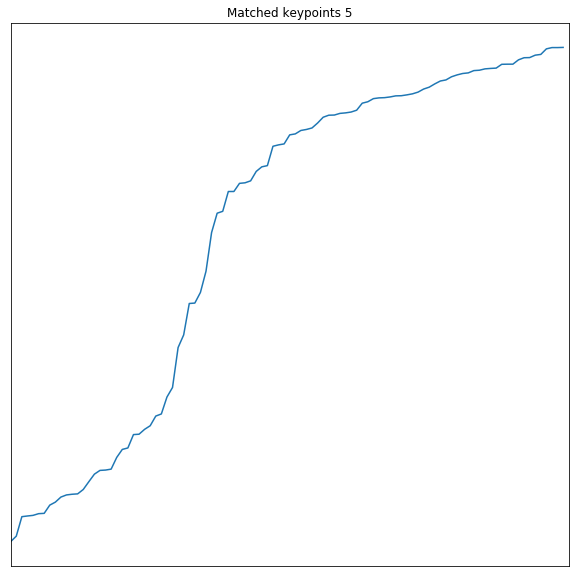

In [26]:
### 2. Scale reference image using scaling factors of (0.2, 0.5, 0.8, 1.25, 2, 5).
# load image 
img_book = cv2.imread("book.jpg")
# convert to RGB
img_book = cv2.cvtColor(img_book, cv2.COLOR_BGR2RGB)

# Get height and width in order
height, width = img_book.shape[0:2] # image size

scales = {0.2, 0.5, 0.8, 1.25, 2, 5}
img_book_scaled = {}

# 3. Compute SIFT keypoints for the transformed images
# create a SIFT object
sift = cv2.xfeatures2d.SIFT_create() # replace with SURF_create() for SURF features
title = "Matched keypoints {}"
for scale in sorted(scales):
    # Create a rotated, scaled duplicate
    # rotation marix around the center pixel, 0 degrees,scale of 0.2, 0.5, 0.8, 1.25, 2, 5
    # Actually get the pivot, so it not necessary is 1/2
    M_scaled = cv2.getRotationMatrix2D((width/2,height/2),0,scale)
    # Apply the transformation matrix
    # Why i need the size of the image: if I transform it (rotate it) the object is actually out of the image
    img_book_scaled[scale] = cv2.warpAffine(img_book,M_scaled,(width,height))
    # detect SIFT features, with no masks
    # 'None' is a mask but here is no masks so it is none
    # Sometime we want to just compute the key points just in the mask
    img_book_cpoy = img_book.copy()
    image_scaled_copy = img_book_scaled[scale].copy()
    keypoints,descriptors = sift.detectAndCompute(img_book_cpoy,None)
    keypoints_scaled,descriptors_scaled = sift.detectAndCompute(image_scaled_copy, None) 
    # create BFMatcher object
    # BF == brute force
    bf = cv2.BFMatcher()#cv2.NORM_HAMMING, crossCheck=True)
    # 4. Match all keypoints of the reference image to the transformed images using a brute-force method.
    # Match descriptors.
    # Match the first arguement to the second
    matches = bf.match(descriptors,descriptors_scaled) #query image, train image
    # 5. Sort matching keypoints according to the matching distance. (2 points)
    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)
    # 6. Display top ten matched keypoints for each pair of reference image and a transformed image.     
    # Draw first 10 matches.
    img_matches = cv2.drawMatches(img_book_cpoy,keypoints
                                  ,image_scaled_copy,keypoints_scaled, matches[:10], None, flags=2)
    plt.figure(figsize=(20,20))
    plt.imshow(img_matches)
    plt.title(title.format(scale)), plt.xticks([]), plt.yticks([])
    plt.show()
    
    # num of SIFT keypoints/descriptors
    print('descriptors size: '+ str(descriptors.shape))

#     for match in sorted(matches):
        # plot the 256x1 np array using matplotlib plot()
    plt.figure(figsize=(10,10))
    x = []
    y = []
    i = 0
    for match in matches[:100]:
        x.append(i)
        y.append(match.distance)
        i = i + 1
    plt.plot(x,y)
    plt.ylabel("Distance")
    plt.xlabel("Indices of keypoints")
    plt.xlim([0,100]) # set x-axis limit
    plt.title(title.format(scale)), plt.xticks([]), plt.yticks([])
    plt.show()

### 1.2 Invariance under Rotation

descriptors size: (385, 128)


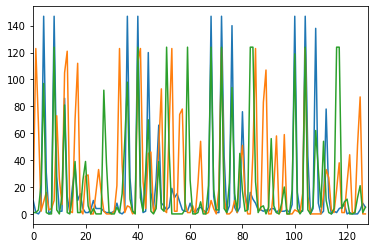

In [27]:
# load image 
img_book = cv2.imread("book.jpg")
# copy image
img_disp_book = img.copy()
# convert to RGB
img_book = cv2.cvtColor(img_book, cv2.COLOR_BGR2RGB)
img_disp = cv2.cvtColor(img_disp_book, cv2.COLOR_BGR2RGB)

# create a SIFT object
sift = cv2.xfeatures2d.SIFT_create() # replace with SURF_create() for SURF features

# 1. Compute SIFT keypoints for the reference image.

# compute SIFT descriptors
# Every row give you one key point
# Cant have multiple key points in one descriptors
# The row is the descriptor and column is the 
keypoints_origin, descriptors_origin = sift.compute(img_book, keypoints)
print('Num keypoints: '+ str(len(keypoints)))

# Alternatively, we can use keypoints,descriptors = sift.detectAndCompute(img) to get both

# num of SIFT keypoints/descriptors
print('descriptors size: '+ str(descriptors_origin.shape))

# plot a couple of 1x128 SIFT descriptors
num = 3
for i in range(num):
    # plot the 256x1 np array using matplotlib plot()
    plt.plot(descriptors_origin[i])
    plt.xlim([0,128]) # set x-axis limit
plt.show()

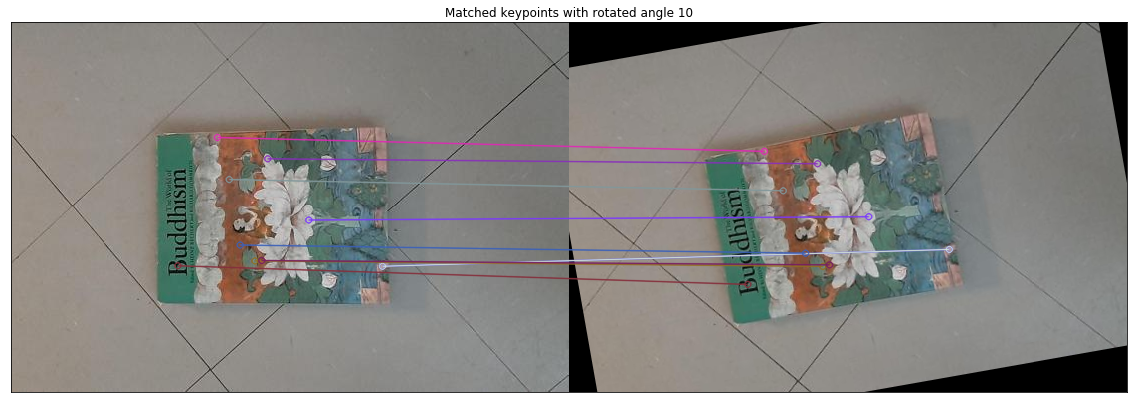

descriptors size: (385, 128)


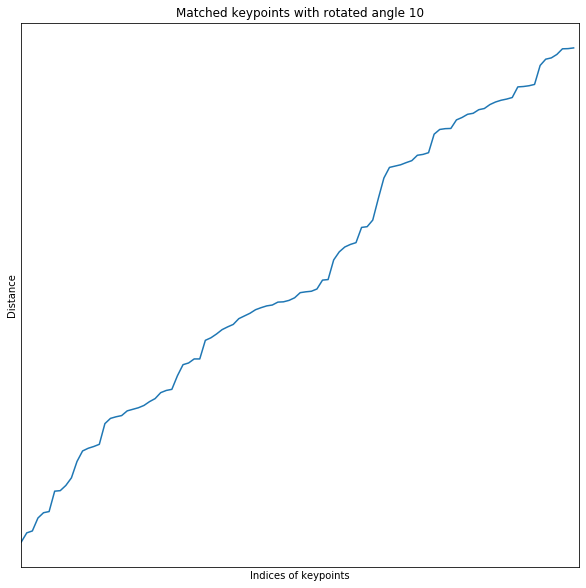

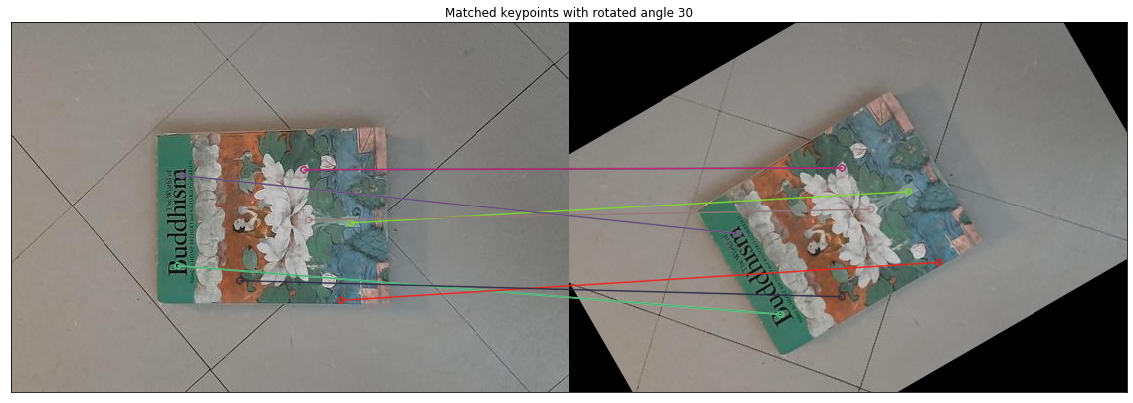

descriptors size: (385, 128)


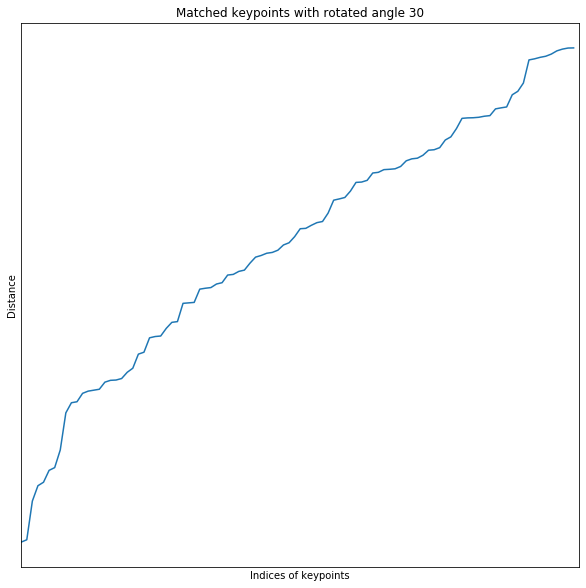

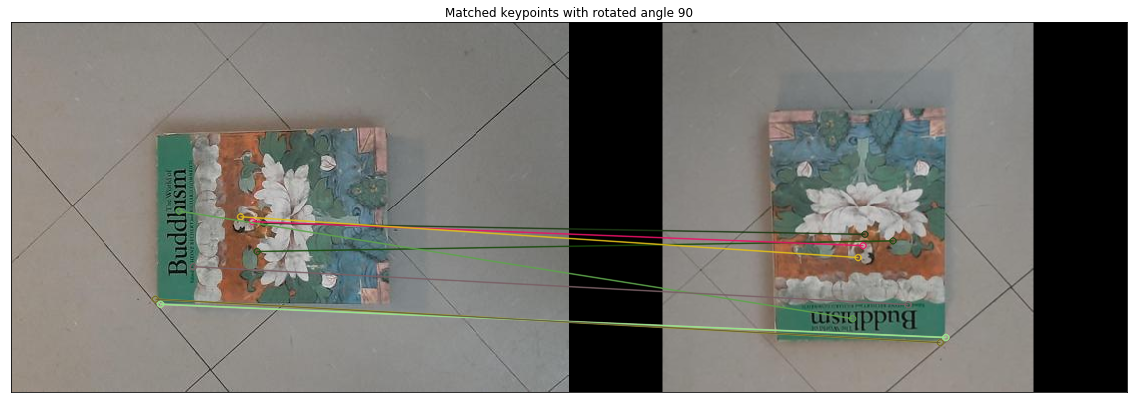

descriptors size: (385, 128)


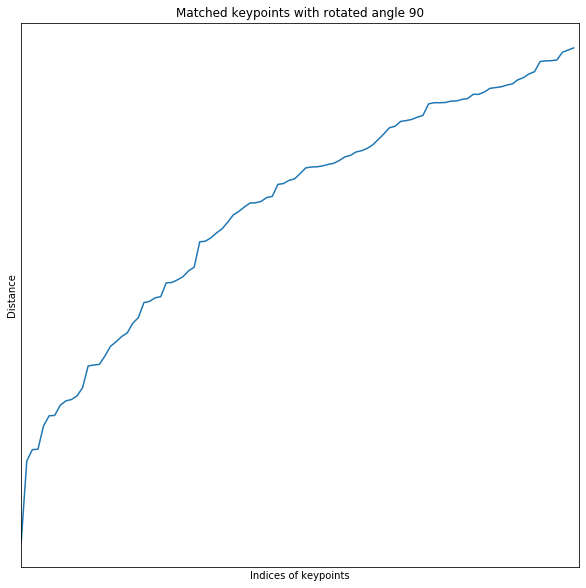

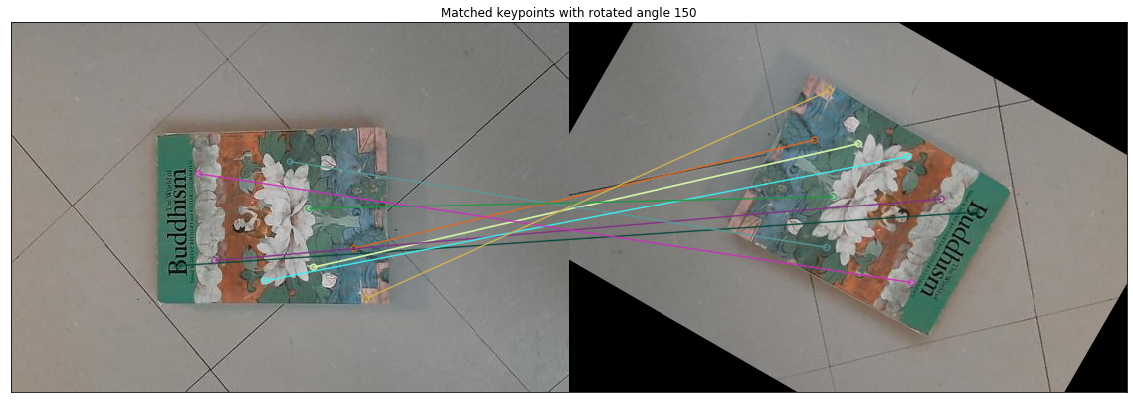

descriptors size: (385, 128)


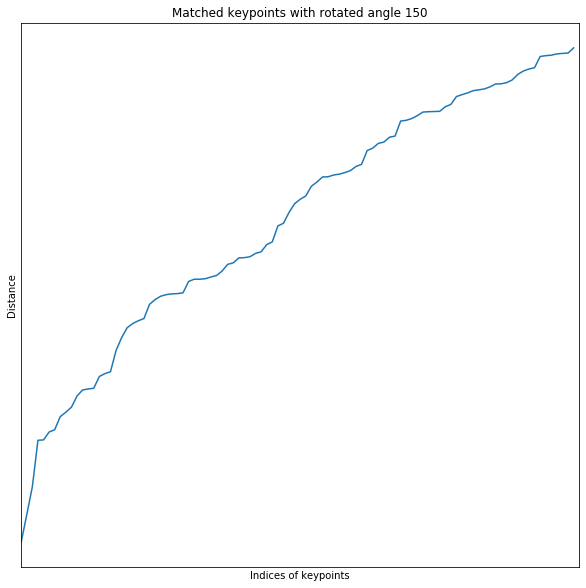

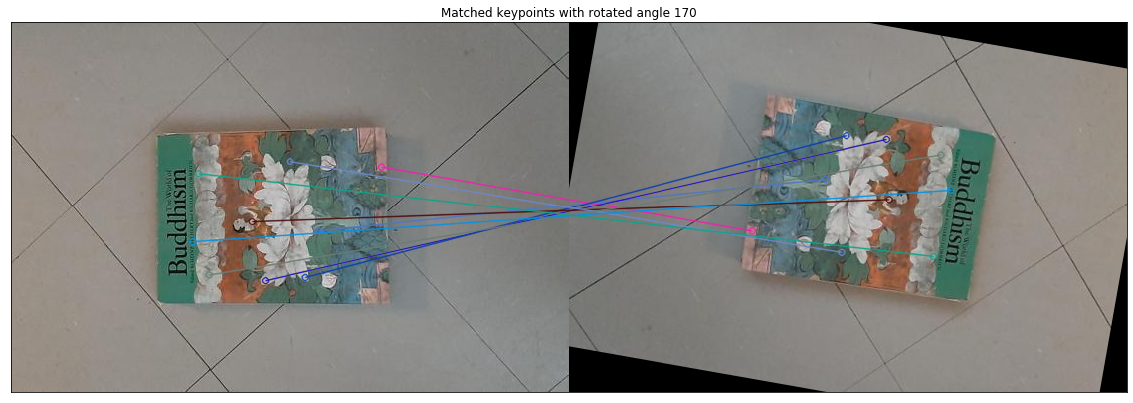

descriptors size: (385, 128)


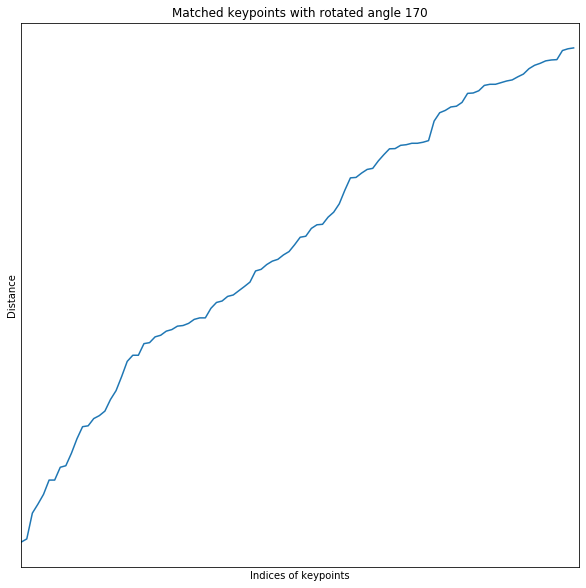

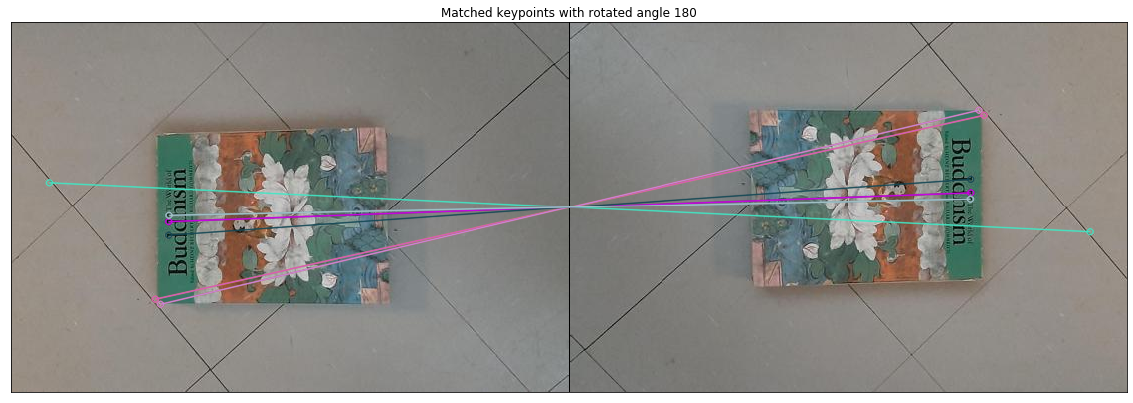

descriptors size: (385, 128)


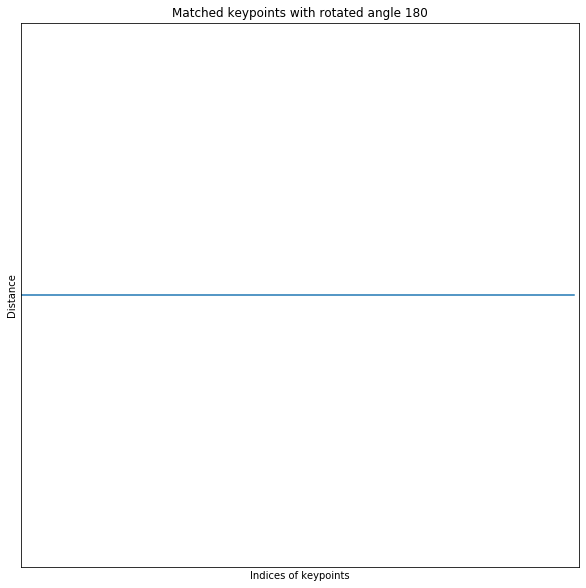

In [31]:
# load image 
img_book = cv2.imread("book.jpg")
# copy image
img_disp_book = img_book.copy()
# convert to RGB
img_book = cv2.cvtColor(img_book, cv2.COLOR_BGR2RGB)
img_disp = cv2.cvtColor(img_disp_book, cv2.COLOR_BGR2RGB)

height, width = img_book.shape[0:2] # image size

angles = {10,30,90,150,170,180}
image_book_rotated = {}

# create a SIFT object
sift = cv2.xfeatures2d.SIFT_create() # replace with SURF_create() for SURF features

title = "Matched keypoints with rotated angle {}"


# 2. Rotate reference image at the angle of (10,30,90,150,170,180) degrees.
for angle in sorted(angles):
    # Create a rotated, scaled duplicate
    # rotation marix around the center pixel, 10,30,90,150,170,180 degrees,scale of 1
    # Actually get the pivot, so it not necessary is 1/2
    M_rotated = cv2.getRotationMatrix2D((width/2,height/2),angle,1)
    # Apply the transformation matrix
    # Why i need the size of the image: if I transform it (rotate it) the object is actually out of the image
    image_book_rotated[angle] = cv2.warpAffine(img_book,M_rotated,(width,height))
    # detect SIFT features, with no masks
    # 'None' is a mask but here is no masks so it is none
    # Sometime we want to just compute the key points just in the mask
    img_book_cpoy = img_book.copy()
    image_rotated_copy = image_book_rotated[angle].copy()
    keypoints,descriptors = sift.detectAndCompute(img_book_cpoy,None)
    keypoints_rotated,descriptors_rotated = sift.detectAndCompute(image_rotated_copy, None) 
    # create BFMatcher object
    # BF == brute force
    bf = cv2.BFMatcher()#cv2.NORM_HAMMING, crossCheck=True)\
    # Match descriptors.
    # Match the first arguement to the second
    matches = bf.match(descriptors,descriptors_rotated) #query image, train image
    # 5. Sort matching keypoints according to the matching distance. (2 points)
    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)
    # 6. Display top ten matched keypoints for each pair of reference image and a transformed image.     
    # Draw first 10 matches.
    img_matches = cv2.drawMatches(img_book_cpoy,keypoints
                                  ,image_rotated_copy,keypoints_rotated, matches[:10], None, flags=2)
    plt.figure(figsize=(20,20))
    plt.imshow(img_matches)
    plt.title(title.format(angle)), plt.xticks([]), plt.yticks([])
    plt.show()
    
        # num of SIFT keypoints/descriptors
    print('descriptors size: '+ str(descriptors.shape))

#     for match in sorted(matches):
        # plot the 256x1 np array using matplotlib plot()
    plt.figure(figsize=(10,10))
    x = []
    y = []
    i = 0
    for match in matches[:100]:
        x.append(i)
        y.append(match.distance)
        i = i + 1
    plt.plot(x,y)
    plt.ylabel("Distance")
    plt.xlabel("Indices of keypoints")
    plt.xlim([0,100]) # set x-axis limit
    plt.title(title.format(angle)), plt.xticks([]), plt.yticks([])
    plt.show()

## 2 Matching using SIFT - Book Reveal

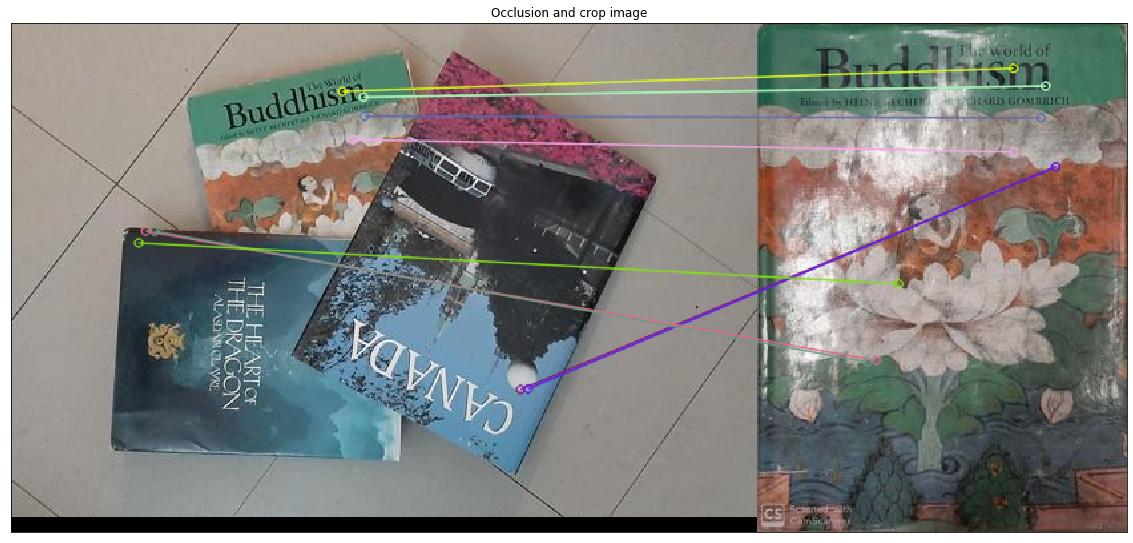

In [18]:
# Find SIFT keypoints in given input images.
# load image 
img_occlusion = cv2.imread("book_occlusion.jpg")
img_crop = cv2.imread("book_crop.jpg")
# copy image
img_occlusion_copy = img_occlusion.copy()
img_crop_copy = img_crop.copy()
# convert to RGB
img_occlusion = cv2.cvtColor(img_occlusion, cv2.COLOR_BGR2RGB)
img_occlusion_copy = cv2.cvtColor(img_occlusion_copy, cv2.COLOR_BGR2RGB)
img_crop = cv2.cvtColor(img_crop, cv2.COLOR_BGR2RGB)
img_crop_copy = cv2.cvtColor(img_crop_copy, cv2.COLOR_BGR2RGB)

# # Create a rotated, scaled duplicate
# # rotation marix around the center pixel, -30 degrees,scale of 1
# # Actually get the pivot, so it not necessary is 1/2
# M_rotated = cv2.getRotationMatrix2D((width/2,height/2),15,0.65)
# # Apply the transformation matrix
# # Why i need the size of the image: if I transform it (rotate it) the object is actually out of the image
# img_crop_copy = cv2.warpAffine(img_crop_copy,M_rotated,(width,height))

# create a SIFT object
sift = cv2.xfeatures2d.SIFT_create() # replace with SURF_create() for SURF features
title = "Occlusion and crop image"
# detect SIFT features, with no masks
# 'None' is a mask but here is no masks so it is none
# Sometime we want to just compute the key points just in the mask
keypoints_occlusion,descriptors_occlusion = sift.detectAndCompute(img_occlusion_copy,None)
keypoints_crop,descriptors_crop = sift.detectAndCompute(img_crop_copy,None)

# create BFMatcher object
# BF == brute force
bf = cv2.BFMatcher()#cv2.NORM_HAMMING, crossCheck=True)\

# Match keypoints of reference image to the keypoints of the occluded image using brute-force method.
# Match descriptors.
# Match the first arguement to the second
matches = bf.match(descriptors_occlusion,descriptors_crop) #query image, train image

# Sort matching keypoints according to the matching distance.
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Display top ten matching keypoints.
# Draw first 10 matches.
img_matches = cv2.drawMatches(img_occlusion_copy,keypoints_occlusion
                              ,img_crop_copy,keypoints_crop, matches[:10], None, flags=2)
plt.figure(figsize=(20,20))
plt.imshow(img_matches)
plt.title(title), plt.xticks([]), plt.yticks([])
plt.show()

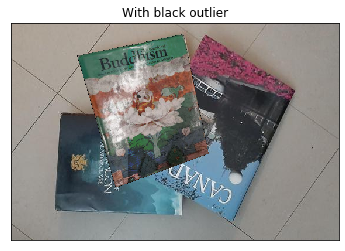

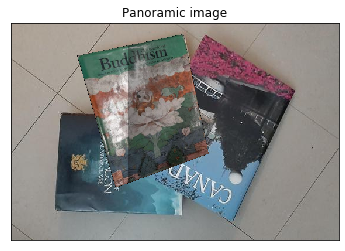

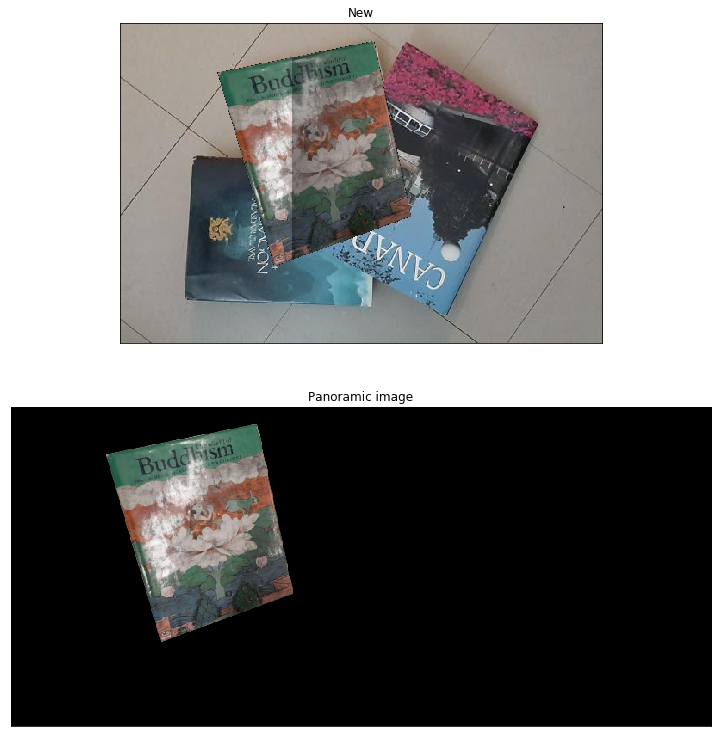

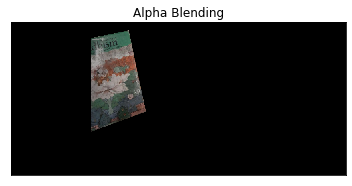

In [43]:
# # Create a rotated, scaled duplicate
# # rotation marix around the center pixel, -30 degrees,scale of 1
# # Actually get the pivot, so it not necessary is 1/2
# M_rotated = cv2.getRotationMatrix2D((width/2,height/2),15,0.65)
# # Apply the transformation matrix
# # Why i need the size of the image: if I transform it (rotate it) the object is actually out of the image
# img_crop_copy = cv2.warpAffine(img_crop_copy,M_rotated,(width,height))

# Compute a homography to align the images using RANSAC method and apply the transformation on the reference image.
# Arrange matching keypoints in two separate lists
GoodMatches = []
for i, m in enumerate(matches):
    if m.distance < 200:
        GoodMatches.append((m.queryIdx, m.trainIdx))
mp_occlusion = np.float32([keypoints_occlusion[i].pt for (i, __) in GoodMatches])
mp_crop = np.float32([keypoints_crop[i].pt for (__, i) in GoodMatches])

H, __ = cv2.findHomography(mp_crop, mp_occlusion, cv2.RANSAC, 1)

wimg = cv2.warpPerspective(img_crop_copy, H, (img_occlusion_copy.shape[1]+img_crop_copy.shape[1]
                                                   ,img_crop_copy.shape[0]))
# B = np.zeros_like(wimg)
B = wimg
for i in range(B.shape[0]):
    for j in range(B.shape[1]):
        for k in range(B.shape[2]):
            if np.all(B[i, j, k] != 0):
                img_occlusion[i,j,k] = B[i,j,k]
                
plt.imshow(img_occlusion)
plt.title("With black outlier"), plt.xticks([]), plt.yticks([])
plt.show()
                
# width and height of image
col, row = wimg.shape[0:2]

""" ALPHA BLENDING """
def Ramp(i_width, c_width, c_index, start, end):
    """
    Create alpha blending function
    :param i_width: img width
    :param r_width: ramp width
    :param r_index: center ramp index
    :param start: starting ramp value
    :param end: ending ramp value
    :return:
    """
    a = np.zeros((i_width))
    step = (end - start) / (c_width-1)
    idx = round(c_index - (c_width / 2))  # left side starting index of alpha ramp
    for i in range(c_width):
        a[idx] = start + step*i
        idx += 1
    a[idx:] = 1
    return a

# alpha blending ramp
ramp_size = 100  # alpha blending ramp size
B = np.zeros_like(wimg)
alpha = Ramp(B.shape[1], ramp_size, 250, 0.65, 1).reshape(1, -1, 1)
# Now blend
I_blend = alpha * wimg + (1-alpha)*B
I_blend = np.uint8(I_blend)  # convert back to uint8
# I_blend = cv2.cvtColor(I_blend, cv2.COLOR_BGR2RGB)
# I_blend = np.zeros_like(I_blend)
for i in range(I_blend.shape[0]):
    for j in range(I_blend.shape[1]):
        for k in range(I_blend.shape[2]):
            if np.all(I_blend[i, j, k] != 0):
                img_occlusion[i,j,k] = I_blend[i,j,k]

plt.imshow(img_occlusion)
plt.title("Panoramic image"), plt.xticks([]), plt.yticks([])
plt.show()
plt.figure(figsize=(20,20))
plt.imshow(img_crop_copy)
plt.title("Matched Keypoints"), plt.xticks([]), plt.yticks([])
plt.subplot(312)
plt.imshow(img_occlusion)
plt.title("New"), plt.xticks([]), plt.yticks([])
plt.subplot(313)
plt.imshow(wimg)
plt.title("Panoramic image"), plt.xticks([]), plt.yticks([])
plt.show()
plt.imshow(I_blend)
plt.title("Alpha Blending"), plt.xticks([]), plt.yticks([])
plt.show()


## 3 Object Detection
### Training

14 Ford training images
1 Ford training images


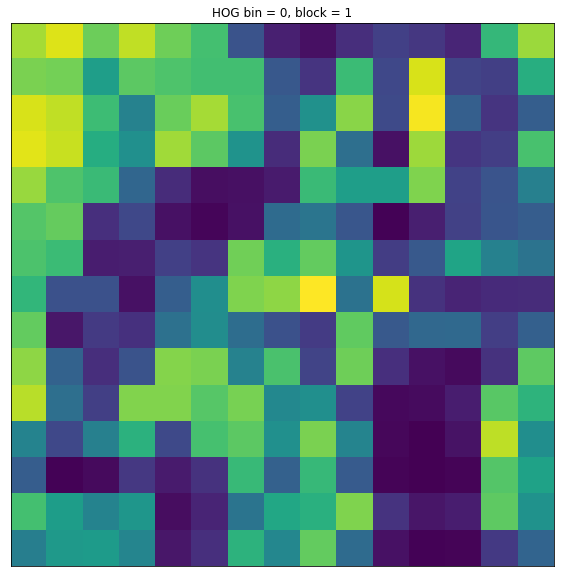

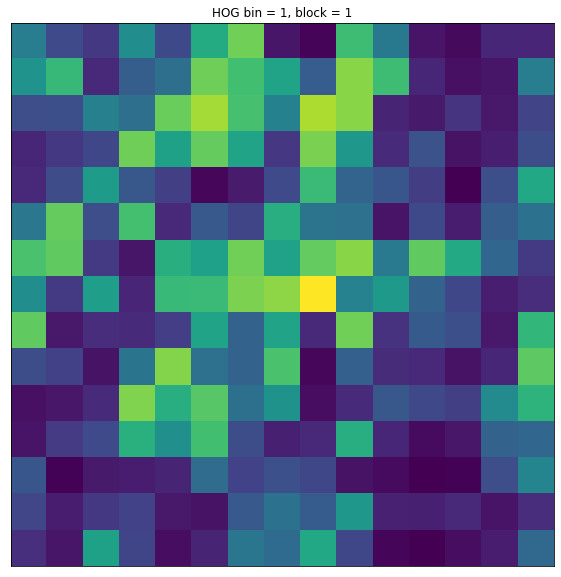

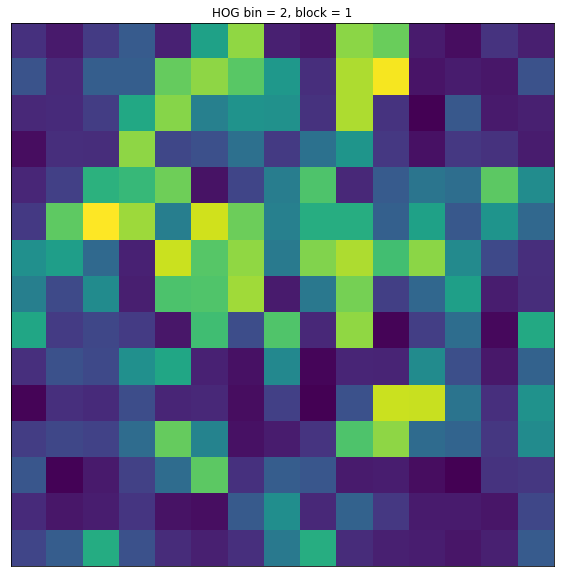

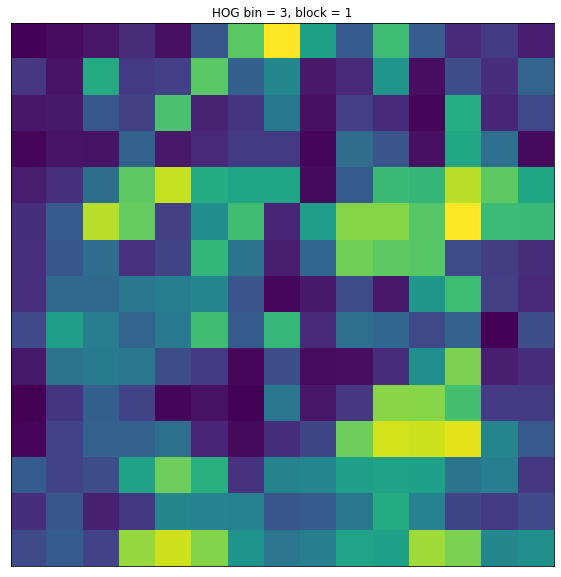

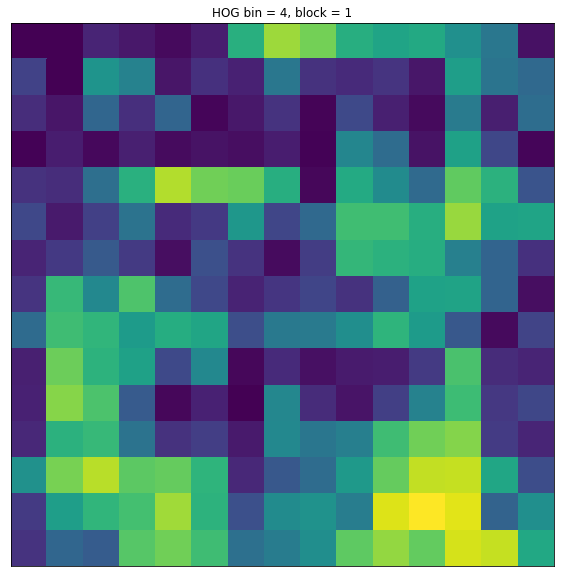

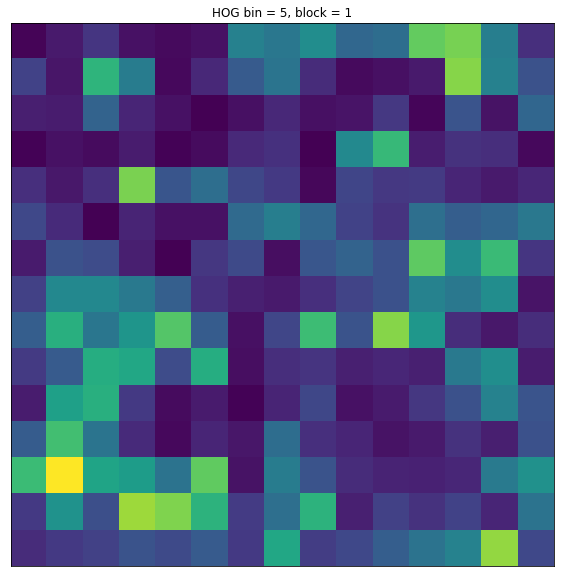

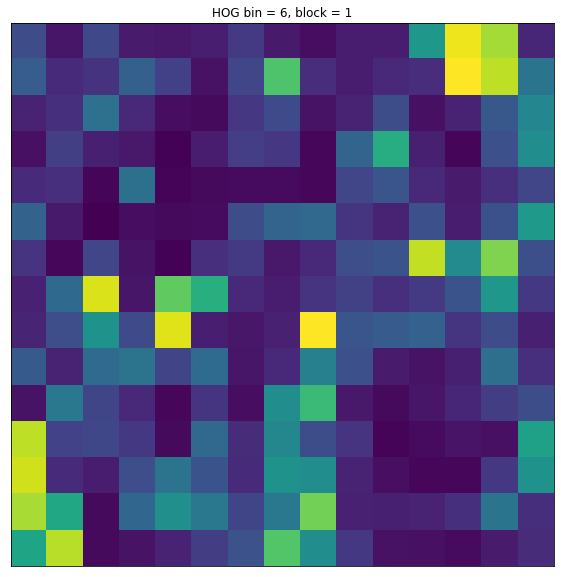

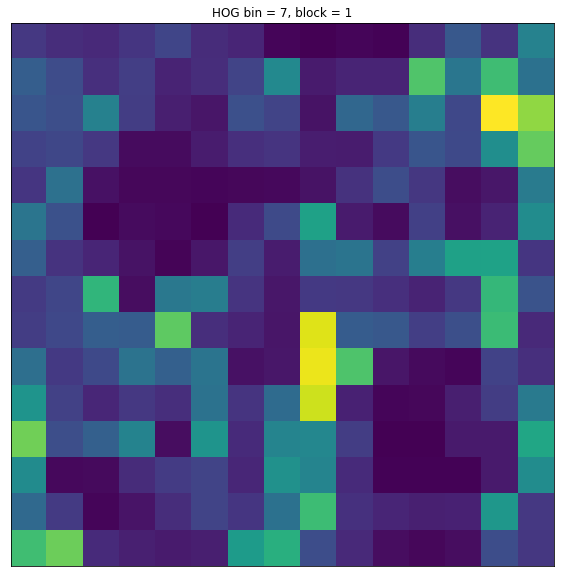

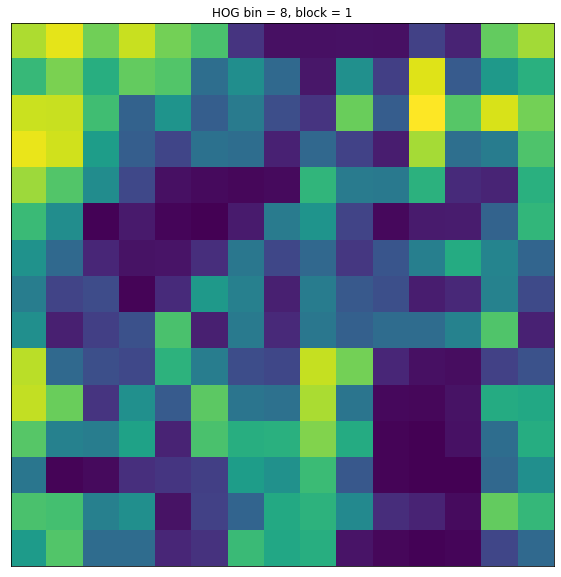

In [16]:
# 1. Resize the training images to 128 x 128.
# Load images and store them in training and test sets 
data = os.listdir('./')
car_train = []
car_test = []
size = (128, 128)

# Resize and store training and test images 
for file in data: 
    if not file.endswith('.jpg'):
        continue
    img = Image.open(file)
    if (len(img.size) == 2): 
        img = img.convert('RGB')  
    img = img.resize(size)
    img = np.array(img)
    
    if file.startswith('car'): 
        car_train.append(img)
    elif file.startswith('test'):
        car_test.append(img)
        
print('{} Ford training images'.format(len(car_train)))
print('{} Ford training images'.format(len(car_test)))

# 2. Compute HoG features using cell size of 4 x 4 pixels, block size of 2 x 2 cells and 9 orientation bins
train_features = HoG_features(car_train)
mean_feature = sum(train_features)/len(train_features)

for i in sorted(range(9)):
    plt.figure(figsize = (10,10))
    plt.pcolor(mean_feature[:, :, 0,0,i])
    #plt.imshow(img, cmap='gray')
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("HOG bin = {}, block = 1".format(i)), plt.xticks([]), plt.yticks([])
